In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
import cv2
import os
from collections import Counter
from tqdm import tqdm
from tensorflow import keras
# 模型文件
from function.ResNet.model import ResNetModel
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,precision_score
from PIL import Image
import matplotlib.pyplot as plt

# 加载测试数据

In [3]:
# TFRecord解析
def parse_function(example1):
    # 特征列
    features = tf.io.parse_single_example(example1, features={
        'data': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        'label': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
    })
    # 数据转换
    features['data'] = tf.io.decode_raw(features['data'], tf.float32)
    features['label'] = tf.cast(features['label'], dtype = tf.int32)
    # 重新reshape成3通道
    skeleton = tf.reshape(features['data'],(100,100,3))
    label = features['label']
    return skeleton, label

def load_dataset(filename,is_train):
    data_reading = tf.data.TFRecordDataset(filename)
    dataset = data_reading.map(parse_function)
    # 在缓冲区中随机打乱数据
    dataset = dataset.shuffle(buffer_size = 99999)
    # 每次加载图片张数
    dataset = dataset.batch(2000)
    return dataset

In [4]:
# 加载测试数据
test_filename = 'data/test_data.tfrecords'
test_datamap = load_dataset(test_filename,False)
for item in test_datamap.take(1):
    # 获取测试数据
    x_test = item[0]
    # 获取测试label
    y_test = list(item[1].numpy())
    w = item[0].shape[1]
    h = item[0].shape[2]
    c = item[0].shape[3]

# 实例化模型

In [5]:
# 获取label数量
my_class_path = 'data/trainlabel_list.npy'
my_class = np.load(my_class_path)
label_counts = len(my_class)
# 加载模型结构
Resnetmodel = ResNetModel(input_shape=(w,h,c),classes=label_counts)
ResNet_model = Resnetmodel.ResNet50()
# 设置学习率
learning_rate=0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
ResNet_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
ResNet_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
# 加载最后一次保存的模型
# 这里读取epoch30次的模型，也可以自行修改读取其他checkpoints文件夹中模型
#读取权重文件
ResNet_model.load_weights('checkpoints/resnet_train_30.tf')
#ResNet_model.load_weights('checkpoints/resnet_train_8.tf')

#save_model = ResNet_model

print("模型加载成功！")

模型加载成功！


# 模型评估

In [7]:
#做出预测
y_pred = ResNet_model.predict(x_test)
# 将结果转换为普通数组
y_pred = [np.argmax(x)for x in y_pred]
print('-----------------测试集上得分：-----------------------')
print('Test accuracy_score:',accuracy_score(y_test,y_pred))
print('\nTest Classification report:\n',classification_report(y_test,y_pred))

-----------------测试集上得分：-----------------------
Test accuracy_score: 1.0

Test Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00       154
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       146
           4       1.00      1.00      1.00       219
           5       1.00      1.00      1.00       156
           6       1.00      1.00      1.00       145
           7       1.00      1.00      1.00       146
           8       1.00      1.00      1.00       149
           9       1.00      1.00      1.00       145
          10       1.00      1.00      1.00       152
          11       1.00      1.00      1.00       149
          12       1.00      1.00      1.00       137

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.

# 图片测试

In [8]:
def show_img_class(img_path,class_path):
    # 此处修改加载图片地址,随便选取一张图片
    img = Image.open(img_path)
    plt.figure("Image") # 图像窗口名称
    plt.imshow(img)
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image') # 图像题目
    plt.show()
    # 图片展示
    img = cv2.imread(img_path)
    imgs = []
    imgs.append(img)

    
    # 数据归一化
    x = np.asarray(imgs, np.float32)/255.
    # 预测
    test_pred = ResNet_model.predict(x)
    result = [np.argmax(x)for x in test_pred]
    
    # 结果
    # 获取class数量
    my_class = np.load(class_path)
    print("预测结果为：",result)
    print("模型测试完成，本图片为：",my_class[result[0]])
    

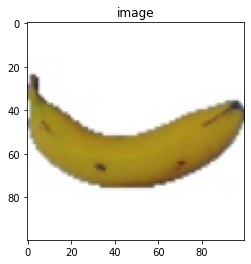

预测结果为： [1]
模型测试完成，本图片为： Banana


In [10]:
# 需要测试的图片地址
path = 'image/test/Banana/113_100.jpg'
# 标签编码地址
my_class_path = 'data/trainlabel_list.npy'
show_img_class(path,my_class_path)

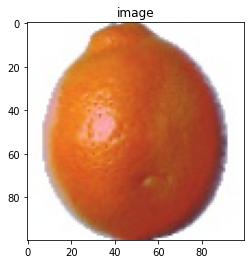

预测结果为： [11]
模型测试完成，本图片为： Tangelo


In [11]:
# 需要测试的图片地址
path = 'image/test/Tangelo/112_100.jpg'
# 标签编码地址
my_class_path = 'data/trainlabel_list.npy'
show_img_class(path,my_class_path)